# Credit Card Anomaly Detection Using Unsupervised Techniques

Anomaly detection is the identification of data points, items, observations or events that do not conform to the expected pattern of a given group. These anomalies occur very infrequently but may signify a large and significant threat such as cyber intrusions or fraud. Anomaly detection is heavily used in behavioral analysis and other forms of analysis in order to aid in learning about the detection, identification and prediction of the occurrence of these anomalies.

##### What to expect?

This notebook will extensively cover 10 steps to achieve fraud detection, so sit back and i will try to be as clear as possible.

    1. Algorithm/Model Selection
    2. Data identification and exploration
    3. Data visualization and presentation
    4. Dataset splitting and training
    5. Dataset pre-processing 
    6. Resampling of data in the dataset
    7. Dataset outlier detection using various algorithms (IForest, LOF, COPOD, and DAN)
    8. Visualization of the outliers and inliers (concentrating more on the outliers)
    9. Evaluation and metrics
    10. Predicting fraudulent transactions with ‘unseen data’

Let's Go!!!

### 1. Algorithm/Model Selection

Anomaly detection can be approached in many ways depending on the nature of data and circumstances. Following is a classification of some of those techniques (https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/)

A system for anomaly detection should NOT be a supervised ML algorithm as it will (maybe) learn only anomalies it has seen during training. The true magic lies in being able to identify an anomaly never seen before...

Some of the algorithms we will test out are;
- Multivariate Gaussian probability
- Auto Encoders
- Local Outlier Factor LOF
- Robust Covariance (Elliptic Envelope)
- Isolation Forest
- One Class SVM

### 2. Data identification and exploration

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Due to confidentiality issues, features from V1 to V28 have been transformed using PCA , the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.

##### Import all modules

In [12]:
# Data Processing and Visualiation
import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

# Modeling
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

# Others
import os
import time
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load Data

df = pd.read_csv('creditcard.csv')
print(df.shape)
print(df.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


As we can see the data has 284,807 observations(rows) and 31 features(columns). Let's break that down a bit

In [10]:
data = df.copy()
normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data size -> ", data.shape)
print("normal_data -> ", normal_data.shape)
print("fraud_data -> ", fraud_data.shape)
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print("_"*120)

data.head()

data size ->  (284807, 31)
normal_data ->  (284315, 31)
fraud_data ->  (492, 31)
No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
________________________________________________________________________________________________________________________


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# A check for Null values!
df.isnull().sum().max()

0

<b>Note</b>: Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

### 3. Data visualization and presentation

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

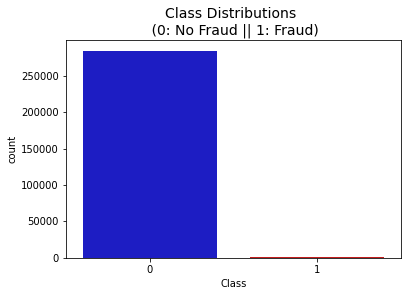

In [13]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)